In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from pckgs.headline_preprocess import HeadlinePreprocess
from pckgs.helper import reduce, custom_split, get_positions
from pckgs.models import get_model_mlp, get_model_single_lstm, \
    train_model, get_model_both_sent, get_model_both_emb
from pckgs.price_preprocess import PricePreprocess
from sklearn.model_selection import train_test_split
from pckgs.evaluator import Evaluator
import numpy as np
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_seq_items = 400

In [40]:
coins = {}
coin_names = ['BTC-USD', 'ETH-USD', 'LTC-USD','BCH-USD']#, 'XLM-USD', 'XRP-USD']

coin_dirs = []
for i in range(len(coin_names)): coin_dirs.append('./datasets/coinbase_day_candles/' + coin_names[i] + '.feather')
coins = {coin_names[i]:coin_dirs[i] for i in range(len(coin_names))}

In [57]:
#resample

problem = 'p'
# problem = 'pp'
# problem = 'pe'

start_timestamp = '2015-01-01 00:00:00'
split_timestamp = '2019-01-30 00:00:00'
end_timestamp = '2019-12-31 23:00:00'

lag = 21
# threshold = 0.25
threshold = 0.5
pp = PricePreprocess(lag, threshold)

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='time', ylabel='close'>

<AxesSubplot:xlabel='time', ylabel='close'>

<AxesSubplot:xlabel='time', ylabel='close'>

<AxesSubplot:xlabel='time', ylabel='close'>

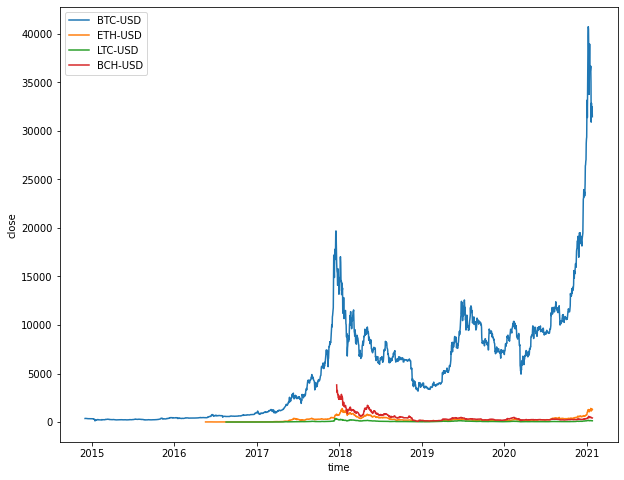

In [26]:
plt.figure(figsize=(10,8))
# plt.ylim(0,5000)
for coin in coins:
    candle = pd.read_feather(coins[coin])
    candle.set_index('time', inplace=True)
    candle.index = candle.index.tz_localize(None)
    sb.lineplot(data=candle, x=candle.index, y='close', label=coin)

In [58]:
# one coin
positions = get_positions(pp, [coins['BTC-USD']])
x_train, y_train, x_test, y_test = custom_split(positions, problem, start_timestamp, split_timestamp, end_timestamp)
y_train.value_counts()
y_test.value_counts()

# #many coins
# positions = get_positions(pp, coins.values())
# x_train, y_train, x_test, y_test = custom_split(positions, problem, start_timestamp, split_timestamp, end_timestamp)
# y_train.value_counts()
# y_test.value_counts()

up      966
down    767
same    495
Name: pChange, dtype: int64
(1491, 3)
(335, 3)


down  same  up
0     0     1     643
1     0     0     499
0     1     0     349
dtype: int64

down  same  up
0     0     1     141
1     0     0     129
0     1     0      65
dtype: int64


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

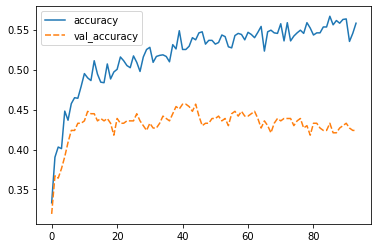

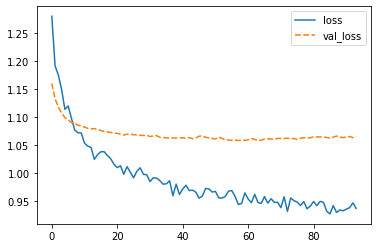

In [52]:
if problem == 'p':
    # model = get_model_single_lstm()
    model = get_model_mlp()
    model, history = train_model(model, (x_train, x_test, y_train, y_test), '../models/model_price.h5', epochs=200)
elif problem =='pp':
    model = get_model_both_sent()
    model, history = train_model(model, (x_train, x_test, y_train, y_test), '../models/model_both_sent.h5', epochs=200)
# elif problem =='pe':
#     model = get_model_both_emb()
#     model, history = train_model(model, (x_train, x_test, y_train, y_test), '../models/model_both_sent.h5', epochs=2)


ac = {'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}
plt.figure()
sb.lineplot(data=ac)

loss = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
plt.figure()
sb.lineplot(data=loss)

(1491, 3)
(335, 3)
              precision    recall  f1-score   support

          -1       0.40      0.10      0.16        98
           0       0.46      0.71      0.55       126
           1       0.42      0.43      0.42       111

    accuracy                           0.44       335
   macro avg       0.42      0.41      0.38       335
weighted avg       0.43      0.44      0.40       335



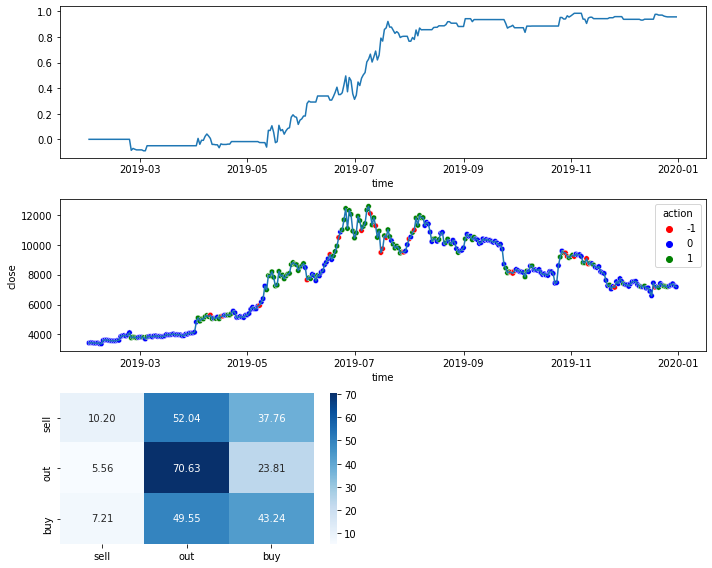

In [53]:
#all coins??? probably a for loop...
coin = 'BTC-USD'
positions = get_positions(pp, [coins[coin]])

force = False
x_train, y_train, x_test, y_test = custom_split(positions, problem, start_timestamp, split_timestamp, end_timestamp)
candle = pd.read_feather(coins[coin])
candle.set_index('time', inplace=True)

test_index = y_test.index
train_index = y_train.index


#create labeled y_test to measure pnl, confusion matrix
y_test_labeled = y_test.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_test_labeled = y_test_labeled.idxmax(axis=1)

y_train_labeled = y_train.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_train_labeled = y_train_labeled.idxmax(axis=1)

test_candle = candle.reindex(test_index)
train_candle = candle.reindex(train_index)


#create labeled y_pred for pnl, confusion matrix
y_pred = model.predict(x_test)
y_pred_labeled = pd.DataFrame(y_pred, columns=[-1, 0, 1], index=test_index)
y_pred_labeled = y_pred_labeled.idxmax(axis=1)

Evaluator.evaluate(y_pred_labeled, y_test_labeled, test_candle, force=force)
print(classification_report(y_test_labeled, y_pred_labeled))

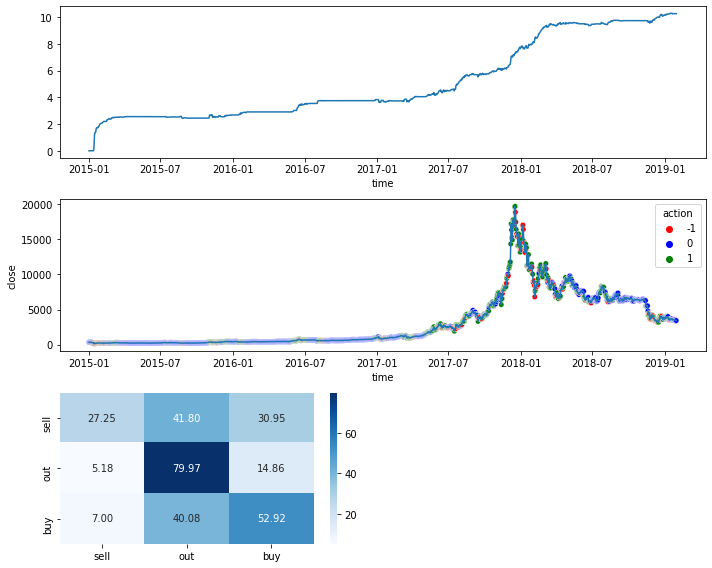

              precision    recall  f1-score   support

          -1       0.61      0.27      0.38       378
           0       0.57      0.80      0.66       599
           1       0.57      0.53      0.55       514

    accuracy                           0.57      1491
   macro avg       0.58      0.53      0.53      1491
weighted avg       0.58      0.57      0.55      1491



In [54]:
y_predt = model.predict(x_train)
y_predt_labeled = pd.DataFrame(y_predt, columns=[-1, 0, 1], index=train_index)
y_predt_labeled = y_predt_labeled.idxmax(axis=1)

Evaluator.evaluate(y_predt_labeled, y_train_labeled, train_candle, force=force)
print(classification_report(y_train_labeled, y_predt_labeled))